# Stout Case Study One 

# # Are Some Transactions Real or Fake? 

In [16]:
# Importing the libraries and dataset.
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score, f1_score,confusion_matrix
from xgboost.sklearn import XGBClassifier
import lightgbm as lgb 
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import plot_importance, to_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report

df = pd.read_csv('..\StoutCaseStudy\PS_20174392719_1491204439457_log.csv\PS_20174392719_1491204439457_log.csv')

# # Exploratory Data Analysis

In [17]:
# Displaying the shape of the dataset.
print(df.shape)

(6362620, 11)


In [18]:
# Displaying the top rows of this dataset.
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [19]:
# Performing a null check on this dataset.
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [20]:
# Selecting and displaying features that are labeled objects.
df.select_dtypes(include = ['object']).head(3)

,type,nameOrig,nameDest
0,PAYMENT,C1231006815,M1979787155
1,PAYMENT,C1666544295,M2044282225
2,TRANSFER,C1305486145,C553264065


In [21]:
# Selecting and displaying features that are integers and floats.
df.select_dtypes(include = ['int64','float64']).head(3)

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0
2,1,181.00,181.0,0.00,0.0,0.0,1,0


# Data Visualizations

0    6354407
1       8213
Name: isFraud, dtype: int64


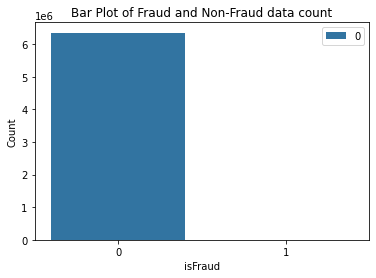

In [22]:
# Plot of data that shows the count of fraud and non-fraud data.
print(df.isFraud.value_counts())
sns.countplot(data = df, x = 'isFraud')
plt.title('Bar Plot of Fraud and Non-Fraud data count')
plt.ylabel('Count')
plt.legend(df['isFraud'])
plt.show()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64


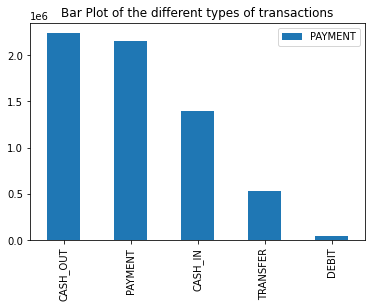

In [23]:
# Bar Plot of the different types of transactions.
print(df.type.value_counts())
plt.title('Bar Plot of the different types of transactions')
df.type.value_counts().plot(kind = 'bar')
plt.legend(df.type)
plt.show()

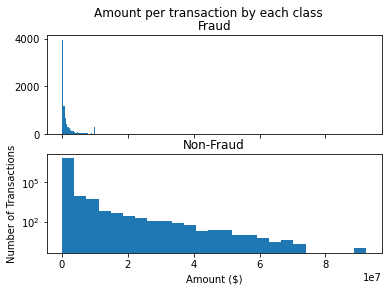

In [24]:
# Histogram of the count of amounts compared to the number of transactions.
fraud = df[df['isFraud'] == 1]
normal = df[df['isFraud'] == 0]
f, (ax1, ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Amount per transaction by each class')
bins = 25
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Non-Fraud')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show();

# Data Pre-Processing

In [25]:
%%time
# Feature extraction
data = df.copy()

# Merchant flag for source and distance of the dataset.
data['OrigC'] = data['nameOrig'].apply(lambda x: 1 if str(x).find('C') == 0 else 0)
data['DestC'] = data['nameDest'].apply(lambda x: 1 if str(x).find('C') == 0 else 0)

# flag for transfer and cashout from type feature.
data['TRANSFER'] = data['type'].apply(lambda x: 1 if x == 'TRANSFER' else 0)
data['CASH_OUT'] = data['type'].apply(lambda x: 1 if x == 'CASH_OUT' else 0)



Wall time: 9.85 s


In [26]:
# Calculating the amount error.
data['OrigAmntErr'] = (abs(data.oldbalanceOrg - data.newbalanceOrig) - data.amount)

# Droping those feature which are id type categories and those which are used for feature extraction.
droplist = ['isFlaggedFraud','type','nameDest','nameOrig']

# Print result
def model_result(clf,x_test,y_test):
    y_prob = clf.predict_proba(x_test)
    y_pred = clf.predict(x_test)
    print('AUPRC :', (average_precision_score(y_test, y_prob[:, 1])))
    print('F1 - score :',(f1_score(y_test,y_pred)))
    print('Confusion_matrix : ')
    print(confusion_matrix(y_test,y_pred))
    print("accuracy_score")
    print(accuracy_score(y_test,y_pred))
    print("classification_report")
    print(classification_report(y_test,y_pred))
    

# Droping features in a droplist and creating X and y for spliting dataset into test and train sets.
MLData = data.drop(labels = droplist, axis = 1)
X = MLData.drop('isFraud',axis = 1)
Y = MLData.isFraud


# Splinting data into X_train, X_test, y_train, y_test sets.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42, shuffle = False)

# Machine Learning Process with XGBoost and Random Forest

## XGBoost with Class Weights

In [27]:
# Testing with XGBoost and class weights.
weights = (Y == 0).sum() / (1.0 * (Y == 1).sum()) 
clf = XGBClassifier( scale_pos_weight = weights, n_jobs = 4, random_state = 42)
clf.fit(X_train, y_train)

print ('Test')
model_result(clf, X_test, y_test)

C:\Users\uru49\Anaconda3\lib\site-packages\xgboost\sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:46:34] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test
AUPRC : 0.9999986634851786
F1 - score : 0.9996717365138418
Confusion_matrix : 
[[1904215       1]
 [      2    4568]]
accuracy_score
0.9999984283204089
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       1.00      1.00      1.00      4570

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



## XGBoost without Class Weights

In [28]:
# Testing again without class weights
clf2 = XGBClassifier()
clf2.fit(X_train, y_train)

print ('Test')
model_result(clf2, X_test, y_test)

[14:51:19] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test
AUPRC : 0.999983387914339
F1 - score : 0.9996717365138418
Confusion_matrix : 
[[1904215       1]
 [      2    4568]]
accuracy_score
0.9999984283204089
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       1.00      1.00      1.00      4570

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786



## XGBoost without Class Weight and Higher Test Set

In [29]:
# Split the data to a 40% data split.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.4,random_state = 42, shuffle = False)

# Retesting with the new changes.
clf3 = XGBClassifier()
clf3.fit(X_train, y_train)

print ('Test')
model_result(clf3, X_test, y_test)

[14:54:52] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Test
AUPRC : 0.99999992077039
F1 - score : 0.9998009157873781
Confusion_matrix : 
[[2540024       0]
 [      2    5022]]
accuracy_score
0.9999992141602044
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2540024
           1       1.00      1.00      1.00      5024

    accuracy                           1.00   2545048
   macro avg       1.00      1.00      1.00   2545048
weighted avg       1.00      1.00      1.00   2545048



## Random Forest with New Data Split

In [30]:
# Splitting the data to a 30% data split.
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42, shuffle = False)

# Random Forest with the new data split.
r_clf = RandomForestClassifier()
r_clf.fit(X_train, y_train)

print ('Test')
model_result(r_clf, X_test, y_test)

Test
AUPRC : 0.9999998085682993
F1 - score : 0.9997811337272926
Confusion_matrix : 
[[1904216       0]
 [      2    4568]]
accuracy_score
0.9999989522136059
classification_report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1904216
           1       1.00      1.00      1.00      4570

    accuracy                           1.00   1908786
   macro avg       1.00      1.00      1.00   1908786
weighted avg       1.00      1.00      1.00   1908786

